In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys, time
stdin, stdout, stderr = sys.stdin, sys.stdout, sys.stderr
import tensorflow as tf
import lm_dataset, lm_model
from utils import data_utils, model_utils
sys.stdin, sys.stdout, sys.stderr = stdin, stdout, stderr
from os.path import expanduser
HOME = expanduser("~")

Building prefix dict from /usr/local/lib/python2.7/dist-packages/synonyms/data/vocab.txt ...
Loading model from cache /tmp/jieba.u4ce22e8452a5a628ef9a1ba508b45102.cache
Loading model cost 0.763 seconds.
Prefix dict has been built succesfully.


In [2]:
vocab_file = HOME+"/Data/Vocab/vocab_zh"
word_vocab_file = HOME+"/Data/Vocab/word_vocab_zh"
embedding_files = HOME+"/Data/Vocab/zh_char_300_nlpcc.txt"
data_dir = HOME+"/Data/text_zh"
train_dir = ''

batch_size = 32
max_length = 128

vocab_dim = 300
size = 256
num_layers = 3

In [3]:
def create_dataset(session, vocab):

    data_paths = {
        'train': [os.path.join(data_dir, "train"), 'repeat'],
        'valid': [os.path.join(data_dir, "dev"), 'one-shot']}
    dataset = lm_dataset.LM_Dataset(
        vocab,
        batch_size,
        data_paths,
        max_len=max_length,
        segmented=False)
    dataset.init(session)
    return dataset

In [4]:
def create_model(session, seqs, segs, vocab, word_vocab, trainable):
    """Create language model and initialize or load parameters in session."""
    kwargs = {'segs': [segs],
              'block_type': 'transformer',
              'decoder_type': 'attn',
              'loss_type': 'sup',
              'model': 'ultra_lm',
              'embedding_init': vocab.embedding_init,
              'dropout': 0.1,
              'wd': 1e-7}

    """Create word_ids array"""
    word_list = map(lambda i: word_vocab.idx2key(i), range(word_vocab.size()))
    count_list = map(lambda i: word_vocab.key2count(i), word_list)
    word_ids_array = np.array(data_utils.labels_to_ids_array(word_list, vocab))
    word_count_array = np.array(count_list, dtype=np.float32)
    kwargs['word_ids_array'] = word_ids_array
    kwargs['word_count_array'] = word_count_array

    """Create model"""
    model = lm_model.LM_Model(
        [seqs],
        True,
        vocab.size(), vocab_dim,
        size, num_layers,
        **kwargs)
    model.init(session, train_dir, kwargs)

    return model

LR finder

In [5]:
"""Train a language model."""
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, gpu_options=tf.GPUOptions(visible_device_list='2'))) as sess:
    # Read data into buckets and compute their sizes.
    vocab = data_utils.Vocab(
        vocab_file,
        embedding_files=embedding_files)
    vocab_size = vocab.size()
    if embedding_files != "":
        vocab_dim = vocab.embedding_init.shape[1]
    word_vocab = data_utils.Vocab(
        word_vocab_file)

    # Create model.
    dataset = create_dataset(sess, vocab)
    seqs, segs = dataset.next_batch
    with tf.device('/gpu:0'):
        model = create_model(sess, seqs, segs, vocab, word_vocab, True)

    # This is the training loop.
    num_iters = 1000
    losses = []
    lrs = np.logspace(-7, -1, num_iters)
    for i, lr in enumerate(lrs):
        start_time = time.time()
        input_feed = {dataset.handle: dataset.handles['train'], model.learning_rate: lr}
        output_feed = [model.loss_list, model.update]
        step_loss, _ = model.step(sess, input_feed, output_feed, training=True)
        step_time = (time.time() - start_time)
        step_loss = sum(step_loss)
        losses.append(step_loss)
        print("iter %s\tloss: %s\tstep time: %s" % (i, step_loss, step_time))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


<tf.Variable 'lm/embed/char_embedding:0' shape=(9089, 300) dtype=float32_ref>
<tf.Variable 'lm/embed/spellin/layer0/weights:0' shape=(300, 256) dtype=float32_ref>
<tf.Variable 'lm/embed/spellin/layer0/weights_norm:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'lm/embed/spellin/layer0/biases:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'lm/embed/spellin/layer1/weights:0' shape=(256, 256) dtype=float32_ref>
<tf.Variable 'lm/embed/spellin/layer1/weights_norm:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'lm/embed/spellin/layer1/biases:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'lm/embed/LayerNorm/beta:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'lm/embed/LayerNorm/gamma:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'lm/embed/spellout/weights:0' shape=(256, 256) dtype=float32_ref>
<tf.Variable 'lm/embed/spellout/weights_norm:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'lm/embed/spellout/biases:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'lm/embed/word_embedding_ke

Created model with fresh parameters. 
iter 0	loss: 16.99574613571167	step time: 3.10314106941
iter 1	loss: 19.089104652404785	step time: 0.266299962997
iter 2	loss: 17.021242141723633	step time: 0.309007883072
iter 3	loss: 16.835136890411377	step time: 0.331194162369
iter 4	loss: 16.70011568069458	step time: 0.260852098465
iter 5	loss: 16.806134700775146	step time: 0.25502204895
iter 6	loss: 16.84457302093506	step time: 0.277619123459
iter 7	loss: 16.69351577758789	step time: 0.249534845352
iter 8	loss: 16.786749839782715	step time: 0.267171859741
iter 9	loss: 16.671058177947998	step time: 0.261936903
iter 10	loss: 16.57047462463379	step time: 0.261452913284
iter 11	loss: 16.525898456573486	step time: 0.323741197586
iter 12	loss: 16.526971340179443	step time: 0.241194009781
iter 13	loss: 16.889602184295654	step time: 0.314007997513
iter 14	loss: 16.657814979553223	step time: 0.263287067413
iter 15	loss: 16.637179374694824	step time: 0.216473817825
iter 16	loss: 16.67921257019043	step t

iter 139	loss: 15.844493389129639	step time: 0.271430969238
iter 140	loss: 15.940629959106445	step time: 0.256011962891
iter 141	loss: 15.815792560577393	step time: 0.265520811081
iter 142	loss: 15.7984299659729	step time: 0.281103134155
iter 143	loss: 15.890513896942139	step time: 0.222388029099
iter 144	loss: 15.922064304351807	step time: 0.250586986542
iter 145	loss: 15.792259216308594	step time: 0.217242002487
iter 146	loss: 15.95097303390503	step time: 0.259506940842
iter 147	loss: 15.744082927703857	step time: 0.203873872757
iter 148	loss: 15.47016429901123	step time: 0.241348028183
iter 149	loss: 15.841446876525879	step time: 0.309572935104
iter 150	loss: 15.90316390991211	step time: 0.248144865036
iter 151	loss: 15.701008796691895	step time: 0.29838013649
iter 152	loss: 15.571338653564453	step time: 0.227970838547
iter 153	loss: 15.370954513549805	step time: 0.257262945175
iter 154	loss: 15.63692045211792	step time: 0.211217880249
iter 155	loss: 15.886579036712646	step time: 0.

iter 277	loss: 12.781877040863037	step time: 0.258083105087
iter 278	loss: 12.800837516784668	step time: 0.24360203743
iter 279	loss: 12.890700817108154	step time: 0.224791049957
iter 280	loss: 12.721970558166504	step time: 0.239795923233
iter 281	loss: 12.586286544799805	step time: 0.210583925247
iter 282	loss: 12.429533004760742	step time: 0.226554870605
iter 283	loss: 12.427059173583984	step time: 0.264964818954
iter 284	loss: 12.680074214935303	step time: 0.213208913803
iter 285	loss: 12.693130493164062	step time: 0.277554988861
iter 286	loss: 12.852115631103516	step time: 0.235978126526
iter 287	loss: 12.579157829284668	step time: 0.251470088959
iter 288	loss: 12.288822650909424	step time: 0.250957965851
iter 289	loss: 12.6062650680542	step time: 0.203767061234
iter 290	loss: 12.818007469177246	step time: 0.218825101852
iter 291	loss: 12.689820289611816	step time: 0.255131959915
iter 292	loss: 12.548332691192627	step time: 0.238966941833
iter 293	loss: 12.82961368560791	step time:

iter 415	loss: 11.16022777557373	step time: 0.223832130432
iter 416	loss: 11.477198600769043	step time: 0.292329072952
iter 417	loss: 11.04844331741333	step time: 0.249433040619
iter 418	loss: 11.630127906799316	step time: 0.232907056808
iter 419	loss: 11.59602689743042	step time: 0.230711936951
iter 420	loss: 11.227063655853271	step time: 0.223106145859
iter 421	loss: 11.413999557495117	step time: 0.235051870346
iter 422	loss: 11.212801456451416	step time: 0.267501831055
iter 423	loss: 11.027307510375977	step time: 0.224204063416
iter 424	loss: 11.357890605926514	step time: 0.267410993576
iter 425	loss: 11.06820821762085	step time: 0.236197948456
iter 426	loss: 11.068246364593506	step time: 0.204457044601
iter 427	loss: 11.282846450805664	step time: 0.227406024933
iter 428	loss: 11.171357154846191	step time: 0.235812902451
iter 429	loss: 11.343854427337646	step time: 0.236979961395
iter 430	loss: 11.189356803894043	step time: 0.214437961578
iter 431	loss: 11.373215675354004	step time:

iter 553	loss: 10.793787479400635	step time: 0.245407819748
iter 554	loss: 10.478229522705078	step time: 0.263938188553
iter 555	loss: 10.289754390716553	step time: 0.207335948944
iter 556	loss: 10.416016101837158	step time: 0.22785782814
iter 557	loss: 10.50041675567627	step time: 0.245436906815
iter 558	loss: 10.812225341796875	step time: 0.253015995026
iter 559	loss: 10.413087844848633	step time: 0.247090816498
iter 560	loss: 10.436499118804932	step time: 0.265918016434
iter 561	loss: 10.55793809890747	step time: 0.276268005371
iter 562	loss: 10.438715934753418	step time: 0.255972146988
iter 563	loss: 10.201557636260986	step time: 0.26269698143
iter 564	loss: 10.41304063796997	step time: 0.282033920288
iter 565	loss: 11.20261812210083	step time: 0.210587978363
iter 566	loss: 11.03460693359375	step time: 0.230756998062
iter 567	loss: 10.365690231323242	step time: 0.242226839066
iter 568	loss: 10.130125999450684	step time: 0.207535028458
iter 569	loss: 10.487635612487793	step time: 0.

iter 691	loss: 10.580589294433594	step time: 0.208114862442
iter 692	loss: 10.410190105438232	step time: 0.261336088181
iter 693	loss: 10.138155937194824	step time: 0.236397027969
iter 694	loss: 10.345531463623047	step time: 0.291544914246
iter 695	loss: 10.406107425689697	step time: 0.257401943207
iter 696	loss: 10.62196969985962	step time: 0.244546890259
iter 697	loss: 10.29633092880249	step time: 0.197749853134
iter 698	loss: 10.654428005218506	step time: 0.278516054153
iter 699	loss: 10.447790622711182	step time: 0.260275125504
iter 700	loss: 10.159154415130615	step time: 0.203266859055
iter 701	loss: 10.540465831756592	step time: 0.237066984177
iter 702	loss: 9.982593059539795	step time: 0.254227876663
iter 703	loss: 10.493910789489746	step time: 0.240391016006
iter 704	loss: 10.540834903717041	step time: 0.294764995575
iter 705	loss: 10.511138439178467	step time: 0.2119140625
iter 706	loss: 10.342305183410645	step time: 0.242347955704
iter 707	loss: 10.657124996185303	step time: 

iter 829	loss: 10.696439743041992	step time: 0.253215074539
iter 830	loss: 10.562398433685303	step time: 0.206587076187
iter 831	loss: 10.936482429504395	step time: 0.214836120605
iter 832	loss: 10.669991970062256	step time: 0.260810852051
iter 833	loss: 10.07666301727295	step time: 0.261581897736
iter 834	loss: 10.451314449310303	step time: 0.214110851288
iter 835	loss: 10.635730266571045	step time: 0.256636142731
iter 836	loss: 10.445499897003174	step time: 0.202214956284
iter 837	loss: 10.710707187652588	step time: 0.189570903778
iter 838	loss: 10.697336196899414	step time: 0.224018096924
iter 839	loss: 10.749017238616943	step time: 0.2192299366
iter 840	loss: 10.68477725982666	step time: 0.270290136337
iter 841	loss: 10.599942684173584	step time: 0.257979154587
iter 842	loss: 10.394081592559814	step time: 0.237024068832
iter 843	loss: 10.62511682510376	step time: 0.276501893997
iter 844	loss: 10.630795955657959	step time: 0.26970911026
iter 845	loss: 10.812305927276611	step time: 0

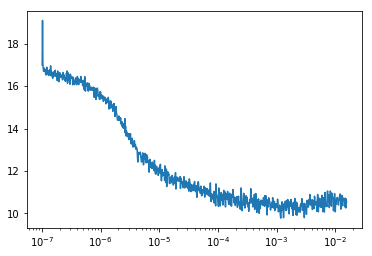

In [6]:
plt.semilogx(lrs[:len(losses)],losses)